### **Inverse Problems: Final Project**
#### *Green’s function estimation from ambient noise signals in 2D*
##### **Author**: Naïl Khelifa

In [25]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.fftpack as fft

## Preliminaries

The homogeneous two-dimensional Green's function $\hat{G}(\omega, x, y)$ is a solution to the equation

$$
\Delta_x \hat{G} + \frac{\omega^2}{c_0^2} \hat{G} = -\delta(x - y), \quad x \in \mathbb{R}^2
$$

with the Sommerfeld radiation condition. It is given by:

$$
\hat{G}(\omega, x, y) = \frac{i}{4} H^{(1)}_0 \left( \frac{\omega}{c_0} |x - y| \right)
$$

where $H^{(1)}_0(s)$ is the Hankel function defined as:

$$
H^{(1)}_0(s) = J_0(s) + i Y_0(s)
$$

In this equation, $J_0$ is the Bessel function of the first kind of order zero, and $Y_0$ is the Bessel function of the second kind of order zero. (For more details, see `scipy.special`).


##### **Question 1**: find the expression of the time-dependent Green's function $G(t, \bm{x}, \bm{y})$ in the two-dimensional situation. 

On rappelle que le lien entre la time-harmonic Green's function et la time-dependent Green's function est donné par la transformation de Fourier suivante: 
$$
\hat{G}(\omega, \bm{x}, \bm{y}) = \int G(t, \bm{x}, \bm{y})e^{i\omega t}dt.
$$
Ainsi, la transformée de Fourier inverse donne la relation suivante, 
$$
G(t, \bm{x}, \bm{y}) = \frac{1}{2\pi} \int \hat{G}(w, \bm{x}, \bm{y})e^{-i \omega t} d\omega.
$$
Or on a, 
$$
\hat{G}(\omega, \bm{x}, \bm{y}) = \frac{i}{4} H^{(1)}_0 \left( \frac{\omega}{c_0} |\bm{x} - \bm{y}| \right).
$$
En insérant le résultat, 
$$
G(t, \bm{x}, \bm{y}) = \frac{i}{8\pi} \int H^{(1)}_0 \left( \frac{\omega}{c_0} |\bm{x} - \bm{y}| \right) e^{-i \omega t} d\omega.
$$
La quantité qui nous intéresse, et que l'on cherche donc à calculer est $\int H^{(1)}_0 \left( \frac{\omega}{c_0} |\bm{x} - \bm{y}| \right) e^{-i \omega t} d\omega$.

Pour cela on remarque que l'expression de la solution fondamentale de l'équation des ondes transitoires en dimension 2,

$$
\frac{1}{c_0^2}\frac{\partial^2 U}{\partial^2 t} - \Delta_{\bm{x}} U = \delta(t) \delta(\bm{x} - \bm{y}),
$$

est donnée par :

$$
U(t, \bm{x}, \bm{y}) = \frac{\Theta(t - \frac{|\bm{x} - \bm{y}|}{c_0})}{2\pi \sqrt{t^2 - \frac{|\bm{x} - \bm{y}|^2}{c_0^2}}},
$$

où $\Theta$ est la fonction de Heaviside en $0$. Or, en appliquant la transformée de Fourier à cette équation, on remarque que l'on retombe sur l'équation de Helmholtz :

$$
\Delta_{\bm{x}} U + \frac{\omega^2}{c_0^2} \hat{U} = - \delta(\bm{x} - \bm{y}).
$$

Mais nous savons que, par définition, $\hat{G}(\omega, \bm{x}, \bm{y})$ dont l'expression est donnée précédemment est une solution de cette équation. Ainsi, on a que 

$$
U(t, \bm{x}, \bm{y}) = \frac{1}{2\pi} \int \hat{G}(w, \bm{x}, \bm{y})e^{-i \omega t} d\omega = G(t, \bm{x}, \bm{y}).
$$

Ainsi, il en découle que, 
$$
\boxed{G(t, \bm{x}, \bm{y}) = \frac{\Theta(t - \frac{|\bm{x} - \bm{y}|}{c_0})}{2\pi \sqrt{t^2 - \frac{|\bm{x} - \bm{y}|^2}{c_0^2}}}.}
$$

## 1. **Empirical cross correlation - full aperture**

On  commence par définir les constantes retenues dans le cadre du stetup expérimental. 

In [23]:
# Constants
c0 = 1  # Propagation speed
L = 50  # Radius of the source distribution
omega = np.linspace(0.01, 10, 1000)  # Frequency range

On définit ensuite $\hat{G}$ et $\hat{F}$ données par l'énoncé et $G$ tel que calculé. 

In [24]:
# Define the 2D Green's function from equation (8)
def G_hat(omega, x, y):
    r = np.linalg.norm(x - y)
    return (1j / 4) * sp.hankel1(0, omega * r / c0)

# Define F(omega) from the problem statement
def F_hat(omega):
    return omega**2 * np.exp(-omega**2)

def G(t, x, y):
    r = np.linalg.norm(x - y)
    heaviside = int(t - r / c0 >= 0)
    res = heaviside / (2 * np.pi * np.sqrt(t**2 - (r/c0)**2))
    return res

On rappelle que, 
$$
u(t, \bm{x}) = \int_{-\infty}^t \int_{\mathbb{R}^2} G(t-s, \bm{x}, \bm{y}) n(s, \bm{y}) d\bm{y} ds
$$
Ainsi, pour pouvoir générer $u$, il nous faut pouvoir générer $n$. On utilise alors le fait que l'on peut générer $n(t, \bm{x})$ par la formule, 
$$
n(t, \bm{x}) = \frac{1}{\sqrt{N}} \sum_{i=1}^N n_s(t)\delta(\bm{x} - \bm{y}_s)
$$
où,
- $(\bm{y}_s)_{s = 1, ..., N}$ are sampled independently and uniformly on the surface $\partial B(0, L)$, 
- $n_s(t)$ are independently and identically emitted signals by each of these points ($\bm{y}_s$) with stationary Gaussian statistics, mean zero, and covariance function $F(t - t')$.

### 1. **Génération du champ aléatoire $n(t,\bm{x})$**

We fix a time horizon $T$ and try to model a random field of noise sources uniformly distributed over the sphere $\partial B(0, L)$ with center $0$ and radius $L$.

#### 1.1. **Génération des $\bm{y}_s$**

On commence par générer les $\bm{y}_s$, que l'on trace ci-dessous pour $N=100$.

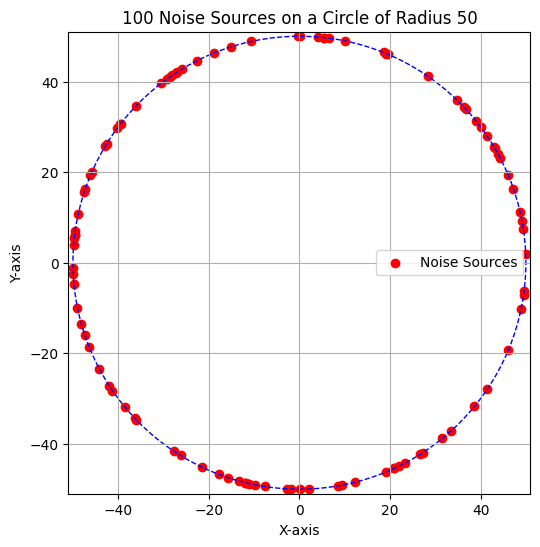

In [ ]:
def sample_ys(N, L=50):
    # Simulation: Generate N noise sources uniformly on a circle of radius L
    theta = np.random.uniform(0, 2 * np.pi, N)  # Random angles

    # Compute x, y coordinates
    x = L * np.cos(theta)
    y = L * np.sin(theta)

    sources = np.column_stack((x, y))

    return sources, x, y

N = 100
L = 50
sources, x, y = sample_ys(N)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, y, color='red', label='Noise Sources')  # Plot points
circle = plt.Circle((0, 0), L, color='blue', fill=False, linestyle='dashed')  # Draw the circle
ax.add_patch(circle)

# Formatting
ax.set_xlim(-L-1, L+1)
ax.set_ylim(-L-1, L+1)
ax.set_aspect('equal')  # Equal aspect ratio
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title(f"{N} Noise Sources on a Circle of Radius {L}")
plt.legend()
plt.grid(True)
plt.show()

#### 1.2. **Génération des $n_s(t)$**


On peut désormais construire les $n_s(t)$, qui, on le rappelle, are independently and identically emitted signals by each of these points ($\bm{y}_s$) with stationary Gaussian statistics, mean zero, and covariance function $F(t - t')$. Pour un ensemble de dates d'émission régulières $t_k = \frac{k}{T-1}$ pour $k \in \{0, ..., T-1\}$ et un horizon de temps T on a 
$$ 
F =
\begin{bmatrix}
F(0) & F(t_1 - t_2) & F(t_1 - t_3) & \dots & F(t_1 - t_T) \\
F(t_2 - t_1) & F(0) & F(t_2 - t_3) & \dots & F(t_2 - t_T) \\
F(t_3 - t_1) & F(t_3 - t_2) & F(0) & \dots & F(t_3 - t_T) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
F(t_T - t_1) & F(t_T - t_2) & F(t_T - t_3) & \dots & F(0)
\end{bmatrix} \in \mathbb{R}^{T \times T}
$$

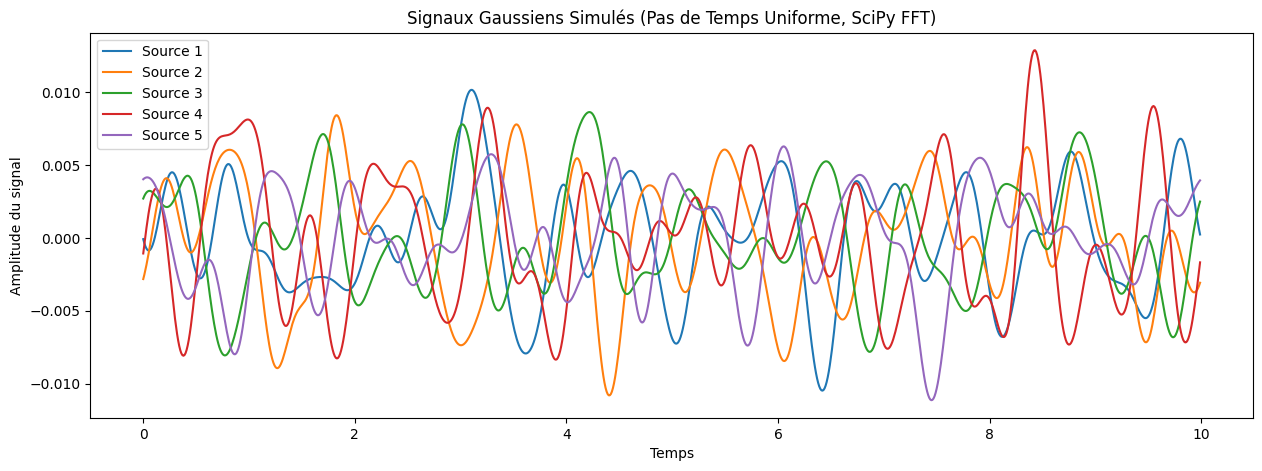

In [ ]:
def n_s(N, T, dt):
    """
    Génère N signaux Gaussiens indépendants avec une covariance F, en utilisant SciPy pour la FFT.

    Paramètres:
    - N  : Nombre de signaux
    - T  : Durée totale des signaux
    - dt : Pas de temps (temps uniformément échantillonné)

    Retourne:
    - signals : Matrice (N, len(time)) des signaux Gaussiens
    - time    : Vecteur des instants de temps
    """
    time = np.arange(0, T, dt)  # Temps avec échantillonnage uniforme
    Nt = len(time)  # Nombre de points temporels
    freq = fft.rfftfreq(Nt, dt)  # Fréquences associées à la FFT
    F_omega = np.sqrt(F_hat(freq))  # Racine du spectre pour obtenir une bonne covariance

    signals = np.zeros((N, Nt))

    for i in range(N):
        spectrum = F_omega * np.random.normal(size=len(freq))  # BRUIT RÉEL
        signal = fft.irfft(spectrum, n=Nt)  # Transformation inverse
        signals[i] = signal

    return signals, time

# Paramètres de simulation
N = 1000    # Nombre de sources
T = 100.0   # Durée des signaux
dt = 0.1  # Pas de temps uniforme

# Étape 2: Génération des signaux Gaussiens indépendants
signals, time = n_s(N, T, dt)

# Tracé des signaux générés
plt.figure(figsize=(15, 5))
for i in range(5):  # Affichage de 5 signaux
    plt.plot(time, signals[i], label=f"Source {i+1}")
plt.xlabel("Temps")
plt.ylabel("Amplitude du signal")
plt.title("Signaux Gaussiens Simulés (Pas de Temps Uniforme, SciPy FFT)")
plt.legend()
plt.show()

In [ ]:
def compute_n_t_x(N_ys, T, dt, grid_size=100, L=50, sigma=1.0):
    """
    Compute n(t, x) on a discrete spatial grid using an approximation of the delta function.

    Parameters:
    - signals  : (N, T) array, where N is the number of sources and T is the number of time steps.
    - sources  : (N, 2) array of (x, y) source positions.
    - grid_size: Number of pixels per spatial dimension.
    - L        : Domain size (spatial grid will be in [-L, L]²).
    - sigma    : Gaussian smoothing parameter for delta function approximation.

    Returns:
    - n_tx : (T, grid_size, grid_size) array representing n(t, x) over time.
    - X, Y : Meshgrid coordinates for visualization.
    """
    sources = sample_ys(N_ys)
    signals, _ = n_s(N_ys, T, dt)
    N, T = signals.shape
    x_vals = np.linspace(-L, L, grid_size)
    y_vals = np.linspace(-L, L, grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Initialize n(t, x) for all timesteps
    n_tx = np.zeros((T, grid_size, grid_size))

    for s in range(N_ys):
        x_s, y_s = sources[s]
        
        # Find nearest grid index
        i = np.argmin(np.abs(x_vals - x_s))
        j = np.argmin(np.abs(y_vals - y_s))
        
        # Accumulate contributions using delta function approximation
        for t in range(T):
            n_tx[t, j, i] += signals[s, t] / np.sqrt(N)

    # Smooth the field for better visualization
    for t in range(T):
        n_tx[t] = gaussian_filter(n_tx[t], sigma=sigma)

    return n_tx, X, Y

# Compute n(t, x) using our previously generated sources and signals
n_tx, X, Y = compute_n_t_x(signals, sources)

# Plot an example frame at t=0
plt.figure(figsize=(6,6))
plt.contourf(X, Y, n_tx[0], levels=50, cmap='coolwarm')
plt.colorbar(label="n(t, x)")
plt.scatter(sources[:, 0], sources[:, 1], color='black', marker='x', label="Sources")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Field n(t, x) at t=0")
plt.legend()
plt.show()


N'oublions pas notre objectif initial qui était de pouvoir définir une routine pour calculer
$$
u(t, \bm{x}) = \int_{-\infty}^t \int_{\mathbb{R}^2} G(t-s, \bm{x}, \bm{y}) n(s, \bm{y}) d\bm{y} ds.
$$
C'est désormais possible puisque l'on sait calculer $n$ et $G$. On approxime l'intégrale par Monte-Carlo sur $N_\text{samples}$.

In [ ]:
def estimate_u_monte_carlo(t, x, G, n, N_ys=100, N=10_000, s_min=10, y_max=10):
    """
    Estime l'intégrale de u(t, x) par Monte-Carlo.

    Paramètres :
    - t : Temps donné
    - x : Position donnée
    - G : Fonction G(t-s, x, y)
    - n : Fonction n(s, y)
    - N : Nombre d'échantillons Monte-Carlo
    - s_min : Valeur minimale pour l'intégration sur s (-s_min, t)
    - y_max : Domaine [-y_max, y_max] x [-y_max, y_max] pour y

    Retourne :
    - Approximation Monte-Carlo de u(t, x)
    """

    # Génération de s dans [-s_min, t]
    s_samples = np.random.uniform(-s_min, t, N)

    # Génération de y dans [-y_max, y_max] × [-y_max, y_max]
    y1_samples = np.random.uniform(-y_max, y_max, N)
    y2_samples = np.random.uniform(-y_max, y_max, N)
    y_samples = np.vstack((y1_samples, y2_samples)).T  # (N, 2)

    # Évaluation de l'intégrande aux points échantillonnés
    integrand_values = np.array([G(t - s, x, y) * n(s, y, N_ys) for s, y in zip(s_samples, y_samples)])

    # Volume de l'espace d'intégration
    volume = (t + s_min) * (2 * y_max) ** 2  # (Intervalle en s) * (Surface en y)

    # Approximation Monte-Carlo
    u_approx = volume * np.mean(integrand_values)

    return u_approx



Consider different pairs of points taken in the array $(x_j, 0)$, with  

$$
x_j = -15 + 5j, \quad j = 1, \dots, 5
$$

for instance.

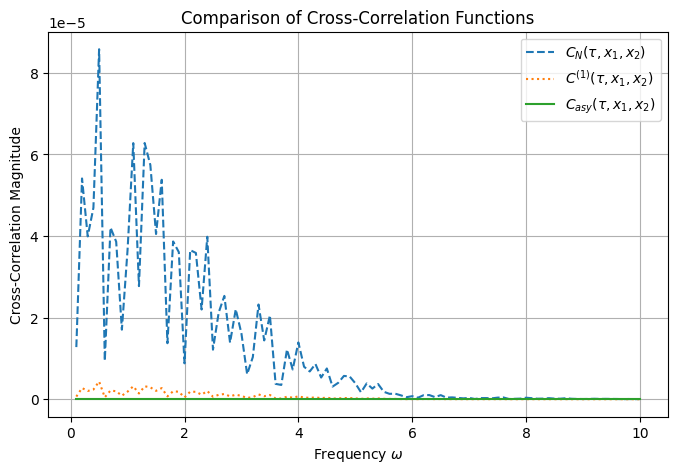

In [ ]:

# Receiver positions
x1 = np.array([10, 0])
x2 = np.array([-10, 0])

# Compute C_N (Expectation of empirical cross-correlation)
CN = np.zeros_like(omega, dtype=complex)
for y in sources:
    CN += F_hat(omega) * G_hat(omega, x1, y) * np.conj(G_hat(omega, x2, y))
CN /= N  # Normalize

# Compute C^(1) (Expectation over noise and source positions)
C1 = np.zeros_like(omega, dtype=complex)
for y in sources:
    C1 += F_hat(omega) * G_hat(omega, x1, y) * np.conj(G_hat(omega, x2, y))
C1 /= (4 * np.pi**2 * L)

# Compute C_asy from equation (6)
F_G_G = np.convolve(F_hat(omega), G_hat(omega, x1, x2), mode='same')
F_G_G_neg = np.convolve(F_hat(omega), G_hat(omega, x2, x1), mode='same')
Casy = (-c0 / (8 * np.pi**2 * L)) * (F_G_G - F_G_G_neg)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(omega, np.abs(CN), label='$C_N(\\tau, x_1, x_2)$', linestyle='dashed')
plt.plot(omega, np.abs(C1), label='$C^{(1)}(\\tau, x_1, x_2)$', linestyle='dotted')
plt.plot(omega, np.abs(Casy), label='$C_{asy}(\\tau, x_1, x_2)$', linestyle='solid')
plt.xlabel('Frequency $\\omega$')
plt.ylabel('Cross-Correlation Magnitude')
plt.legend()
plt.title('Comparison of Cross-Correlation Functions')
plt.grid()
plt.show()